In [221]:
# from google.colab import files
# files.upload()  # Upload kaggle.json

# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c playground-series-s5e7

In [222]:
# !unzip /content/playground-series-s5e7.zip -d /content/playground-series-s5e7

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [74]:
test_df = pd.read_csv('/content/playground-series-s5e7/test.csv')
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [75]:
sub_df = pd.read_csv('/content/playground-series-s5e7/sample_submission.csv')
sub_df.head()

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert


In [76]:
# https://www.kaggle.com/code/metric/accuracy-score
import numpy as np
import pandas as pd
import pandas.api.types
from sklearn.metrics import accuracy_score
import sklearn.metrics

from typing import Sequence, Union, Optional


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, normalize: bool=True, weights_column_name: Optional[str]=None) -> float:
    '''
    Wrapper for https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    Accuracy classification score.

    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.

    Parameters
    ----------
    solution : 1d DataFrame. Ground truth (correct) labels.

    submission : 1d DataFrame. Predicted labels, as returned by a classifier.

    normalize : bool, default=True
        If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.

    weights_column_name: optional str, the name of the sample weights column in the solution file.

    Examples
    --------
    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_pred = [0, 2, 1, 3]
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred["id"] = range(len(y_pred))
    >>> y_true = [0, 1, 2, 3]
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true["id"] = range(len(y_true))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.5
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name, normalize=False)
    2.0
    '''
    # Skip sorting and equality checks for the row_id_column since that should already be handled
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weight = None
    if weights_column_name:
        if weights_column_name not in solution.columns:
            raise ValueError(f'The solution weights column {weights_column_name} is not found')
        sample_weight = solution.pop(weights_column_name).values
        if not pandas.api.types.is_numeric_dtype(sample_weight):
            raise ParticipantVisibleError('The solution weights are not numeric')

    if not((len(submission.columns) == 1) or (len(submission.columns) == len(solution.columns))):
        raise ParticipantVisibleError(f'Invalid number of submission columns. Found {len(submission.columns)}')


    solution = solution.values
    submission = submission.values

    try:
        score_result = accuracy_score(solution, submission, normalize=normalize, sample_weight=sample_weight)
    except Exception as e:
        raise ParticipantVisibleError(str(e))

    return float(score_result)

In [77]:
df = pd.read_csv('/content/playground-series-s5e7/train.csv')
df.head(10)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
5,5,2.0,No,8.0,5.0,No,NaN,3.0,Extrovert
6,6,1.0,No,8.0,NaN,No,NaN,4.0,Extrovert
7,7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
8,8,4.0,Yes,2.0,1.0,NaN,0.0,2.0,Introvert
9,9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert


In [78]:
df.shape

(18524, 9)

In [79]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         6175 non-null   int64  
 1   Time_spent_Alone           5750 non-null   float64
 2   Stage_fear                 5577 non-null   object 
 3   Social_event_attendance    5778 non-null   float64
 4   Going_outside              5709 non-null   float64
 5   Drained_after_socializing  5743 non-null   object 
 6   Friends_circle_size        5825 non-null   float64
 7   Post_frequency             5767 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 386.1+ KB


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [81]:
df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [82]:
for col in df.select_dtypes('object').columns:
  print(f'{col}: {df[col].unique()}')

Stage_fear: ['No' 'Yes' nan]
Drained_after_socializing: ['No' nan 'Yes']
Personality: ['Extrovert' 'Introvert']


In [83]:
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [84]:
df1 = df.copy()

In [85]:
df1['Stage_fear'] = df1['Stage_fear'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
df1['Drained_after_socializing'] = df1['Drained_after_socializing'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

In [86]:
df1.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,0,6.0,4.0,0,15.0,5.0,Extrovert
1,1,1.0,0,7.0,3.0,0,10.0,8.0,Extrovert
2,2,6.0,1,1.0,0.0,0,3.0,0.0,Introvert
3,3,3.0,0,7.0,3.0,0,11.0,5.0,Extrovert
4,4,1.0,0,4.0,4.0,0,13.0,NaN,Extrovert


In [87]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 18524 non-null  int64  
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  18524 non-null  int64  
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 1.3+ MB


## Target based imputation

In [88]:
df1.describe()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,18524.000000,17344.000000,17058.000000,18524.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,0.217124,5.265106,4.044319,0.219283,7.996737,4.982097
std,5347.562529,3.003786,0.412299,2.753359,2.062580,0.413772,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,0.000000,3.000000,3.000000,0.000000,5.000000,3.000000
50%,9261.500000,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000
75%,13892.250000,4.000000,0.000000,8.000000,6.000000,0.000000,12.000000,7.000000
max,18523.000000,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000


In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

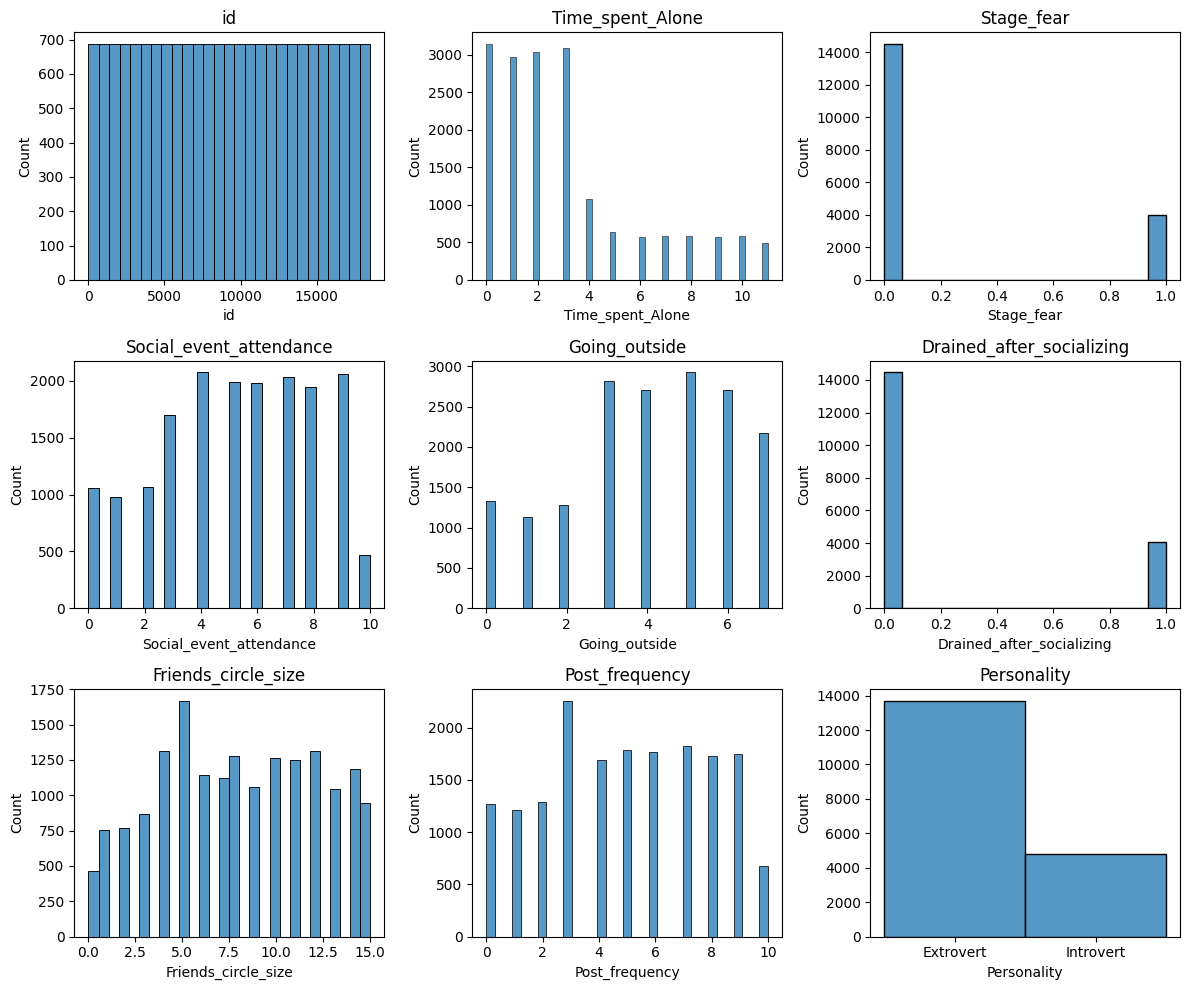

In [90]:
fig, ax = plt.subplots(figsize=(12, 10), ncols=3, nrows=3)
ax=ax.flatten()

for i,col in enumerate(df1.columns[:len(ax)]):
  sns.histplot(df1[col], ax=ax[i])
  ax[i].set_title(col)

plt.tight_layout()
plt.show()

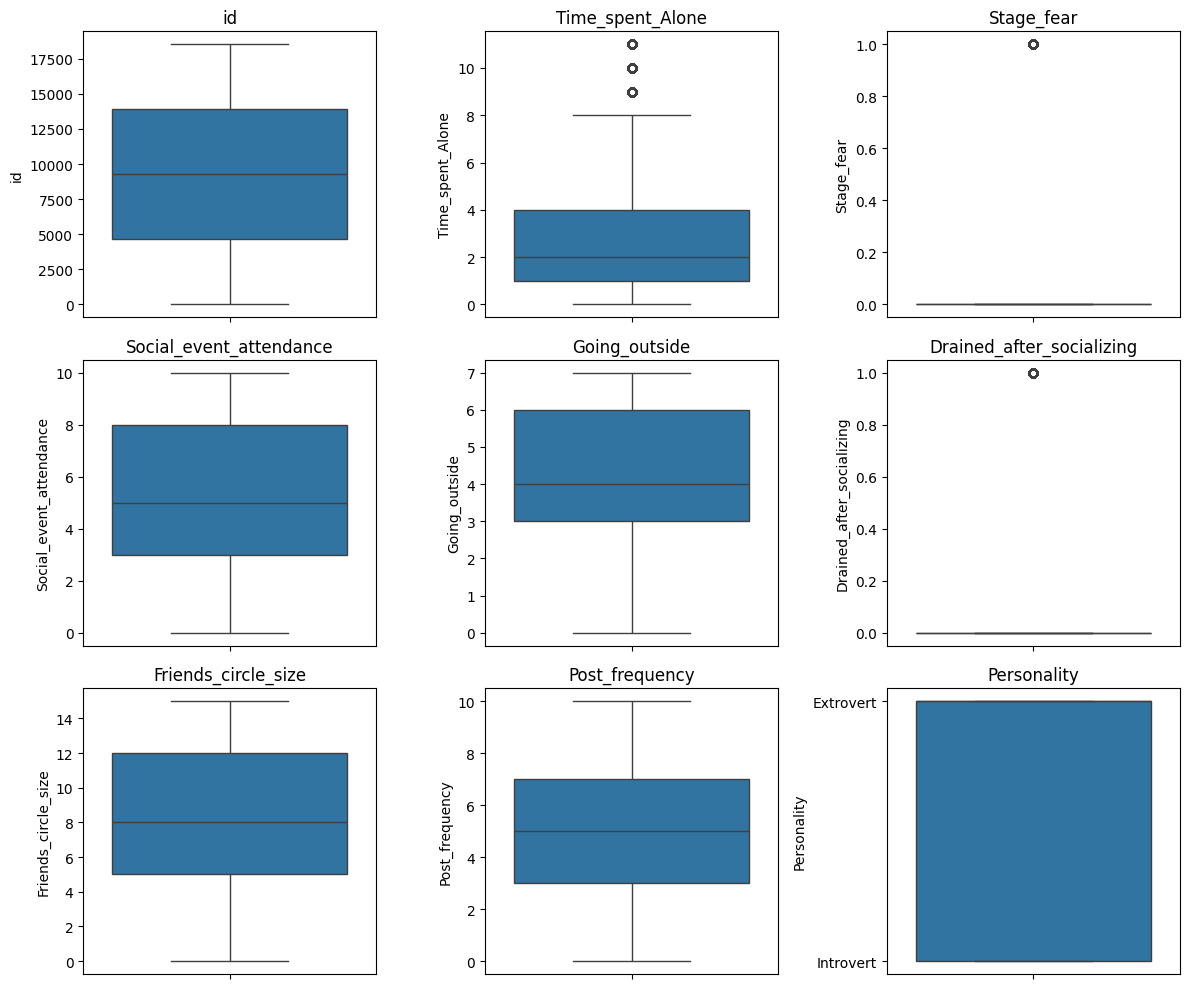

In [91]:
fig, ax = plt.subplots(figsize=(12, 10), ncols=3, nrows=3)
ax=ax.flatten()

for i,col in enumerate(df1.columns[:len(ax)]):
  sns.boxplot(df1[col], ax=ax[i])
  ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [100]:
def targetBasedImputation(df:pd.DataFrame, colName:str)-> pd.DataFrame:
  dataframe = df.copy()
  introvert_df = dataframe[dataframe['Personality'] == 'Introvert']
  extrovert_df = dataframe[dataframe['Personality'] == 'Extrovert']

  introvert_mean = round(introvert_df[colName].mean())
  extrovert_mean = round(extrovert_df[colName].mean())

  dataframe.loc[(dataframe['Personality'] == 'Introvert') & (dataframe[colName].isna()), colName] = introvert_mean
  dataframe.loc[(dataframe['Personality'] == 'Extrovert') & (dataframe[colName].isna()), colName] = extrovert_mean

  return dataframe

In [101]:
df2 = targetBasedImputation(df1, "Time_spent_Alone")

In [102]:
df[df['Time_spent_Alone'].isna()]

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
15,15,NaN,No,7.0,6.0,No,5.0,8.0,Extrovert
29,29,NaN,Yes,1.0,0.0,Yes,4.0,0.0,Introvert
31,31,NaN,No,4.0,NaN,No,11.0,5.0,Extrovert
41,41,NaN,No,6.0,5.0,No,14.0,3.0,Extrovert
62,62,NaN,No,6.0,6.0,No,13.0,4.0,Extrovert
...,...,...,...,...,...,...,...,...,...
18502,18502,NaN,No,4.0,5.0,No,15.0,6.0,Extrovert
18510,18510,NaN,No,NaN,5.0,No,12.0,9.0,Extrovert
18515,18515,NaN,No,9.0,4.0,No,5.0,8.0,Extrovert
18516,18516,NaN,No,6.0,5.0,No,9.0,4.0,Extrovert


In [103]:
df2.iloc[15:33]

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
15,15,2.0,0,7.0,6.0,0,5.0,8.0,Extrovert
16,16,0.0,0,6.0,4.0,0,8.0,10.0,Extrovert
17,17,5.0,0,0.0,4.0,1,2.0,0.0,Introvert
18,18,1.0,0,4.0,4.0,0,11.0,9.0,Extrovert
19,19,1.0,0,NaN,5.0,0,10.0,3.0,Extrovert
20,20,1.0,0,9.0,3.0,0,10.0,7.0,Extrovert
21,21,6.0,1,3.0,2.0,1,1.0,3.0,Introvert
22,22,4.0,0,0.0,1.0,1,2.0,0.0,Introvert
23,23,3.0,0,9.0,7.0,0,6.0,3.0,Extrovert
24,24,1.0,0,5.0,3.0,0,12.0,5.0,Extrovert


In [104]:
df1.columns

Index(['id', 'Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency', 'Personality'],
      dtype='object')

In [96]:
cols = ["Time_spent_Alone", "Stage_fear", "Social_event_attendance", "Going_outside", "Drained_after_socializing", "Friends_circle_size", "Post_frequency"]

In [105]:
df3 = df2.copy()
for col in cols:
    df3 = targetBasedImputation(df3, col)

In [106]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           18524 non-null  float64
 2   Stage_fear                 18524 non-null  int64  
 3   Social_event_attendance    18524 non-null  float64
 4   Going_outside              18524 non-null  float64
 5   Drained_after_socializing  18524 non-null  int64  
 6   Friends_circle_size        18524 non-null  float64
 7   Post_frequency             18524 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(3), object(1)
memory usage: 1.3+ MB


In [107]:
print('here')

here


In [206]:
X = df1.drop(['Personality','id'], axis=1)
y = df1['Personality']

In [207]:
X.head()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0.0,0,6.0,4.0,0,15.0,5.0
1,1.0,0,7.0,3.0,0,10.0,8.0
2,6.0,1,1.0,0.0,0,3.0,0.0
3,3.0,0,7.0,3.0,0,11.0,5.0
4,1.0,0,4.0,4.0,0,13.0,NaN


In [208]:
y = y.apply(lambda x: 1 if x == 'Extrovert' else 0).astype(int)

In [209]:
# X=X.fillna(X.mean(numeric_only=True))

In [210]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [211]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.9654520917678813

In [185]:
y_pred = xgb_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [186]:
!pip install catboost lightgbm

In [198]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),  # silent mode
    'LightGBM': LGBMClassifier()
}

In [199]:
scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores[name] = acc
    print(f"{name}: {acc:.4f}")


Decision Tree: 0.9347
Random Forest: 0.9676
XGBoost: 0.9655
CatBoost: 0.9684
[LightGBM] [Info] Number of positive: 10946, number of negative: 3873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 14819, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.738646 -> initscore=1.038945
[LightGBM] [Info] Start training from score 1.038945
LightGBM: 0.9682


In [178]:
best_model_name = max(scores, key=scores.get)
print(f"\nBest Model: {best_model_name} with accuracy {scores[best_model_name]:.4f}")


Best Model: CatBoost with accuracy 0.9692


In [212]:
solution = pd.DataFrame({
    'row_id': X_test.index,
    'Personality': y_test         # ground truth
})

submission = pd.DataFrame({
    'row_id': X_test.index,
    'Personality': y_pred         # model predictions
})

In [213]:
print(score(solution, submission, row_id_column_name="row_id"))

0.9681511470985156


In [214]:
test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.00000,0,7.0,4.0,0,6.0,4.946394
1,18525,3.14052,0,0.0,0.0,0,5.0,1.000000
2,18526,3.00000,0,5.0,6.0,0,15.0,9.000000
3,18527,3.00000,0,4.0,4.0,0,5.0,6.000000
4,18528,9.00000,0,1.0,2.0,0,1.0,1.000000


In [215]:
test_df['Stage_fear'] = test_df['Stage_fear'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)
test_df['Drained_after_socializing'] = test_df['Drained_after_socializing'].apply(lambda x: 1 if x == 'Yes' else 0).astype(int)

In [216]:
for col in cols:
  test_df[col].fillna(df3[col].mean(), inplace=True)

/tmp/ipython-input-216-3291615366.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df[col].fillna(df3[col].mean(), inplace=True)


In [217]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'Personality': models['CatBoost'].predict(test_df.drop('id', axis=1))
})

In [218]:
submission.head()

,id,Personality
0,18524,1
1,18525,1
2,18526,1
3,18527,1
4,18528,0


In [219]:
submission['Personality']=submission['Personality'].map(lambda x: 'Extrovert' if x == 1 else 'Introvert')
submission.head()

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert


In [220]:
# submission.to_csv('submission.csv', index=False)